In [1]:
# imports 

import gym
import numpy as np 
import pandas as pd 

# for capturing the video / graphs
import cv2 as cv
import matplotlib.pyplot as plt 


# for training nn:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

# for truncated normal distribution
import scipy.stats as stats
import torch.distributions as distributions

# others
import os
import time


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3050 Laptop GPU


**env - CarRacing-v2**

**Policy-Gradients with critic**

(0,)


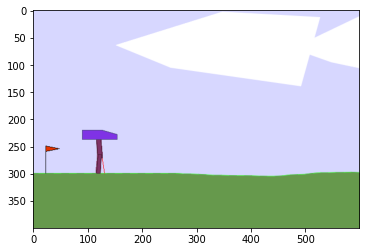

In [4]:
env = gym.make('BipedalWalker-v3',new_step_api='True',render_mode='rgb_array',hardcore=False)
env.reset()
# example image
plt.imshow(np.array(env.render()).squeeze())
print(np.array(env.render()).shape)

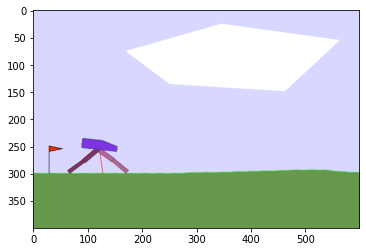

In [41]:
env.reset()
for i in range(100):
   env.step(np.array([1.0,1.0,-1.0,1.0]))
plt.imshow(np.array(env.render()[-1]).squeeze())

In [23]:
# our model : # arch - 2
# arch - 1 : 24 - 256 (actor_fnn) , 256-32,32-4 (var,mu) , val : 24 128 16 1
# arch - 2 : 24 - 48 - 16 - 4 / for Mu and var ; 24 - 48 - 16 - 1 / for critic

class BipedalWalker(nn.Module):
    def __init__(self,prob_dist_params_dim = 4):

        super(BipedalWalker,self).__init__()
        self.output = prob_dist_params_dim


        self.Actor_FNN = nn.Sequential(
            #nn.Linear(24,256),
            #nn.LeakyReLU(),
            #nn.Linear(256,32),
            #nn.LeakyReLU(),
            #nn.Linear(32,self.output),
        )

        self.Var = nn.Sequential(
            nn.Linear(24,512),
            nn.LeakyReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,self.output),
            nn.Sigmoid(),
        )

        self.Mu = nn.Sequential(
            nn.Linear(24,512),
            nn.LeakyReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,self.output),
            nn.Tanh(),
        )

        self.Critic_FNN = nn.Sequential(
            nn.Linear(24,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,32),
            nn.ReLU(),
            nn.Linear(32,1),
        )

    def forward(self,x):
        
        # To calculate the value fn
        value = self.Critic_FNN(x)

        # To calculate the Mu and Variance
        # prob_params = self.Actor_FNN(x)

        # Variance of 3 actions
        Variance = self.Var(x)

        # Mu of 3 actions 
        Mu = self.Mu(x)

        return value , Mu , Variance

In [6]:
# About Model
def about_model(model):
    print(model)
    print(f' total params in the model : {sum(p.numel() for p in model.parameters())}' )
    
about_model(BipedalWalker())

BipedalWalker(
  (Actor_FNN): Sequential()
  (Var): Sequential(
    (0): Linear(in_features=24, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
    (5): Sigmoid()
  )
  (Mu): Sequential(
    (0): Linear(in_features=24, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
    (5): Tanh()
  )
  (Critic_FNN): Sequential(
    (0): Linear(in_features=24, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
 total params in the m

In [93]:

class Car_racing():
    def __init__(self,name,env,lr_critic=0.001,lr_actor=0.0001,gamma=0.99,model=BipedalWalker):

        self.name = name
        self.lr_cr = lr_critic
        self.lr_actor = lr_actor
        self.gamma = gamma
        self.env = env
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # our model will give the normal dist params for each action mu(mean) , sigma(sd)
        self.model = BipedalWalker().to(self.device)
        self.optimizer_critic = torch.optim.Adam(self.model.Critic_FNN.parameters(),lr=self.lr_cr )
        prob_params = nn.ModuleList([self.model.Var , self.model.Mu] )
        self.optimizer_actor = torch.optim.Adam( prob_params.parameters(), lr = self.lr_actor)

        ''' raise Exception(f"test-0 , checking model \n {self.model} ") - Passed '''
    
    def save_load_model(self,name,root_path,key='save'):
        path = os.path.join(root_path,f'{name}.pt')

        if os.path.exists(root_path):

            if key=='load':
                self.model.load_state_dict(torch.load(path,map_location=self.device))
                print('Model Successfully loaded')
            else:
                torch.save(self.model.state_dict(), path)
                print(f'The model named : {name} successfully saved')

        else:
            print(f'No such root_path {root_path} exists to load the model')


    def compute_returns(self,rewards,last_rew,gamma=0.99): # to compute the cumulative reward for the each state
        R = []
        cumulative_reward = last_rew
        rewards = torch.Tensor(rewards).to(self.device)

        for i in rewards:
            cumulative_reward = i + gamma*cumulative_reward
            R.insert(0,cumulative_reward)
        ''' raise Exception(f' Test -2 : \n test for checking the shape of the reward \n The reward length is : {len(R)} ') - passed '''
        return torch.cat(R).detach()
    

    def get_random_variates(self,Mu,Variance): # pass 2 np_array of size '3'

        # to get truncated normal dist in the range(-1,1) 
        # please visit the link https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html to get understanding of the formulae used 
    
        #np_array[1] , np_array[3] , np_array[5] , np_array[4] , np_array[2] = 1/(1+np.exp(-np_array[1])) + 1e-5 , 1/(1+np.exp(-np_array[3])) + 1e-5 , 1/(1+np.exp(-np_array[5])) + 1e-5 , 1/(1+np.exp(-np_array[4])) + 1e-5 , 1/(1+np.exp(-np_array[2])) + 1e-5

        action1_range1 , action1_range2 = (-1 - Mu[0] ) / Variance[0] ,  ( 1 - Mu[0] ) / Variance[0] 
        action2_range1 , action2_range2 = (-1 - Mu[1] ) / Variance[1] ,  ( 1 - Mu[1] ) / Variance[1]
        action3_range1 , action3_range2 = (-1 - Mu[2] ) / Variance[2] ,  ( 1 - Mu[2] ) / Variance[2]
        action4_range1 , action4_range2 = (-1 - Mu[3] ) / Variance[3] ,  ( 1 - Mu[3] ) / Variance[3]
        
        # print(np_array,action1_range1 , action1_range2)

        action1 = stats.truncnorm.rvs(action1_range1 , action1_range2 , loc = Mu[0] , scale = Variance[0])
        action2 = stats.truncnorm.rvs(action2_range1 , action2_range2 , loc = Mu[1] , scale = Variance[1])
        action3 = stats.truncnorm.rvs(action3_range1 , action3_range2 , loc = Mu[2] , scale = Variance[2])
        action4 = stats.truncnorm.rvs(action4_range1 , action4_range2 , loc = Mu[3] , scale = Variance[3])

        actions = np.array([action1 , action2 , action3 , action4 ])

        ''' raise Exception(f" test -1 \n test for actions probs  \n The action taken now is {actions} \n The shape is {actions.shape} \n ") # - Passed '''
        return actions


    def get_log_probs(self,actions,Mu,Variance):
        probs = []
        actions = torch.Tensor(actions).to(self.device)
        
        for i in range(4):
        
            D = distributions.Normal(loc = Mu[i] , scale = Variance[i])
            temp = torch.unsqueeze( D.log_prob( actions[i] ) , 0 )
            probs.append(temp) 

            # k = -( (actions[i] - Mu[i] )**2 / (2*(Variance[i]**2) ) ) - torch.log( Variance[i] )
            # print(k == temp ,k , temp , k-temp )
        # print(Mu)
        ''' raise Exception(f" test -3 \n test for log_prob values \n { ( probs , torch.unsqueeze(probs[2],0) )} \n {actions} ") # - Passed '''
        # print(probs)
        return torch.cat(probs).to(self.device)


    def train_A2C_Car(self,path,epochs,freq=10):
        reward_avg = []

        for e in range(epochs):
            state = self.env.reset(options={'randomize':False})
            # for storing log_probs , values of each state , rewards from each state / action
            rewards = []
            log_probs = []
            vals = []
            n = 400
            r1 = 0

            for i in range(n):

                state = torch.Tensor(state).to(self.device)
                value , Mean , Variance   = self.model(state)
                
                ''' raise Exception(f"{Mean} \n ") # - Passed ''' 

                # changing the params to numpy array
                Mu_numpy = Mean.detach().cpu().numpy()
                Var_numpy = Variance.detach().cpu().numpy()

                actions = self.get_random_variates(Mu_numpy,Var_numpy)
                next_state , r , done , _ , _ = env.step(actions)

                # changing current state 
                state = next_state

                # append rewards , values , log_probability
                rewards.append(r)
                vals.append(value)
                log_probs.append( self.get_log_probs(actions,Mean,Variance) )

                ''' raise Exception(f" log probs :  {log_probs[0]} ") # - Passed '''

                if done == True or i == n-1:
                    
                    state = torch.Tensor(state).to(self.device)
                    value ,_,_ =  self.model(state)
                    values =  torch.cat(vals)
                    log_probs = torch.cat(log_probs)

                    returns = self.compute_returns(rewards=rewards,last_rew=value)
                    advantage =  (returns - values)
                    
                    # print(returns[:10] , values[:10] )
                    ''' raise Exception(f"Test-4 \n checking for grads \n grads for advantage : {advantage.requires_grad} \n grads for log_probs {log_probs.requires_grad} \n advantage size : {advantage.size()} {advantage[:50]}") # - Passed'''

                    # error terms 
                    critic_error = torch.mean(advantage.pow(2))
                    actor_error = torch.mean(-(log_probs * advantage.detach().unsqueeze(1) ) )


                    #print(f' printing grads of the network : {self.model.Actor_FNN[1].bias.grad} ')
                    ''' raise Exception(f" Test - 5 , \n checking the sizes of the error terms \n size of critic error : {critic_error.size} \n size of actor error : {actor_error} \n {log_probs.grad} {values.grad} ") # - passed '''

                    A2C_Loss = actor_error + critic_error
                    self.optimizer_critic.zero_grad()
                    
                    self.optimizer_actor.zero_grad()

                    Mean.retain_grad()
                    #Variance.retain_grad() 

                    A2C_Loss.backward()
                    self.optimizer_critic.step()

                    self.optimizer_actor.zero_grad()

                    # storing reward avg 
                    r_avg = sum(rewards)/len(rewards)
                    reward_avg.append(r_avg)

                    print(f'epoch {e} is finished and total iters : {i} ; done : {done}')
                    ''' raise Exception(f'printing grads of the Actor network[0] : {self.model.Var[0].bias.grad} \n printing kernels grad size : {self.model.Mu[0].weight.grad.size()}) \n grads of mean : {Mean.grad} \n {self.model.Critic_FNN[0].weight.grad[0]} \n ') # -Passed '''
                    break

            if (e+1)%freq == 0:
                #print(f' printing weight matrix of Actor_FNN : {self.model.Actor_FNN[0].weight[0] } ') # printing  
                print(reward_avg[-5:]) # printing last 5 rewards to get an idea whether our Ai is learning or not
                self.save_load_model(root_path = path , name=self.name , key='save')

        return reward_avg

    def train_model(self,save_freq=10,epochs=100,path='./weights/',plot=False):

        name = self.name
        model_path = os.path.join(path,f'{name}.pt')

        if os.path.exists(model_path):
            self.save_load_model(root_path = path , key='load' , name=name)

        reward_history = self.train_A2C_Car(path=path,freq=save_freq,epochs=epochs)

        if plot:
            fig = plt.figure(10,10)
            plt.plot(reward_history,'b.')
            plt.xlabel('iters')
            plt.ylabel('rewards')
            plt.show()

        return reward_history


In [94]:
# Installing our model in this cell 

name = 'Bi_pedal_walker_v3_A3'
env = gym.make('BipedalWalker-v3',new_step_api='True',render_mode='rgb_array',hardcore=False)
model1 = Car_racing(name=name,env=env)

In [108]:
# training our model here
reward_avg = model1.train_model(epochs=100,save_freq=2)

Model Successfully loaded
epoch 0 is finished and total iters : 72 ; done : True
epoch 1 is finished and total iters : 399 ; done : False
[-1.455225173793673, -0.040468281986051347]
The model named : Bi_pedal_walker_v3_A3 successfully saved
epoch 2 is finished and total iters : 79 ; done : True
epoch 3 is finished and total iters : 399 ; done : False
[-1.455225173793673, -0.040468281986051347, -1.3397435807401323, -0.037108563264737375]
The model named : Bi_pedal_walker_v3_A3 successfully saved
epoch 4 is finished and total iters : 85 ; done : True
epoch 5 is finished and total iters : 399 ; done : False
[-0.040468281986051347, -1.3397435807401323, -0.037108563264737375, -1.1959258366487835, -0.03848484489145943]
The model named : Bi_pedal_walker_v3_A3 successfully saved
epoch 6 is finished and total iters : 399 ; done : False
epoch 7 is finished and total iters : 399 ; done : False
[-0.037108563264737375, -1.1959258366487835, -0.03848484489145943, -0.04405594927623493, -0.045263345102

KeyboardInterrupt: 

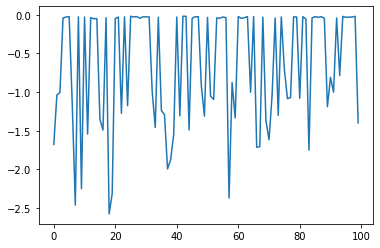

-0.018527687560569134  ; avg :  -0.6583110148781032


In [ ]:
plt.plot(reward_avg,label='avg reward for 1000 episodes')
plt.show()
print( max(reward_avg) , ' ; avg : ' , sum(reward_avg)/len(reward_avg) )

In [ ]:
env.reset()
a = np.array([1.1,0.19,0.79])
for i in range(120):
    l = env.step(a)
plt.imshow(l[0])

In [57]:
with torch.no_grad():
    torch.cuda.empty_cache()
    !nvidia-smi

Sun Sep 18 18:38:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8     7W /  N/A |    810MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# solving some Random  doubts
a11 = torch.Tensor([[1,1,1],[1,1,1]])
b11 = torch.Tensor([2,2.5])
b11 = b11.unsqueeze(1)
c11 = a11 * b11
print(c11,b11.size(),a11.size(),c11.requires_grad)

In [ ]:
stats.truncnorm.rvs(-9.8,-0.9,loc=10,size=10,scale=10)

In [ ]:
env.reset()
n , r ,done , l , _ = env.step([0.1,0.1,0.2])
print(r,done,l,_ )

In [ ]:
t = [torch.Tensor( [[torch.Tensor([1]),torch.Tensor([1])]] ),torch.Tensor( [[torch.Tensor([1]),torch.Tensor([1])]] ) ]
t1 = torch.cat([t[0]])
print(t1)

In [ ]:
dist1 = distributions.Normal(loc = torch.Tensor([1]) , scale = torch.Tensor([1]))
k11 = dist1.log_prob(torch.tensor([1000]))
print(k11.requires_grad)

In [40]:
def get_random_variates(Mu,Variance): # pass 2 np_array of size '3'

        # to get truncated normal dist in the range(-1,1) 
        # please visit the link https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html to get understanding of the formulae used 
    
        #np_array[1] , np_array[3] , np_array[5] , np_array[4] , np_array[2] = 1/(1+np.exp(-np_array[1])) + 1e-5 , 1/(1+np.exp(-np_array[3])) + 1e-5 , 1/(1+np.exp(-np_array[5])) + 1e-5 , 1/(1+np.exp(-np_array[4])) + 1e-5 , 1/(1+np.exp(-np_array[2])) + 1e-5

        action1_range1 , action1_range2 = (-1 - Mu[0] ) / Variance[0] ,  ( 1 - Mu[0] ) / Variance[0] 
        action2_range1 , action2_range2 = (-1 - Mu[1] ) / Variance[1] ,  ( 1 - Mu[1] ) / Variance[1]
        action3_range1 , action3_range2 = (-1 - Mu[2] ) / Variance[2] ,  ( 1 - Mu[2] ) / Variance[2]
        action4_range1 , action4_range2 = (-1 - Mu[3] ) / Variance[3] ,  ( 1 - Mu[3] ) / Variance[3]
        
        # print(np_array,action1_range1 , action1_range2)

        action1 = stats.truncnorm.rvs(action1_range1 , action1_range2 , loc = Mu[0] , scale = Variance[0])
        action2 = stats.truncnorm.rvs(action2_range1 , action2_range2 , loc = Mu[1] , scale = Variance[1])
        action3 = stats.truncnorm.rvs(action3_range1 , action3_range2 , loc = Mu[2] , scale = Variance[2])
        action4 = stats.truncnorm.rvs(action4_range1 , action4_range2 , loc = Mu[3] , scale = Variance[3])

        actions = np.array([action1 , action2 , action3 , action4 ])

        ''' raise Exception(f" test -1 \n test for actions probs  \n The action taken now is {actions} \n The shape is {actions.shape} \n actions_params : {np_array}") # - Passed '''
        return actions

In [41]:
video_converter =  cv.VideoWriter_fourcc(*'mp4v')
video_bipedal_walker = cv.VideoWriter('./videos/A2C_car_racing-2-arch-3-video-2.avi',video_converter,30,(400,600))

In [42]:
def Enhance(agent,name,device):
  torch.no_grad()
  path = os.path.join('./weights/',f'{name}.pt')
  agent.load_state_dict(torch.load(path,map_location=device))
  print(f'The model named : {name} successfully loaded')

In [98]:
def check_training(name,num=1):

  video_converter =  cv.VideoWriter_fourcc(*'mp4v')
  video1 = cv.VideoWriter(f'./video/{name}-video-{num}.avi',video_converter,60,(600,400))

  env = gym.make('BipedalWalker-v3',new_step_api='True',render_mode='rgb_array',hardcore=False)
  torch.no_grad()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)

  agent = BipedalWalker().to(device)
  done=False
  state = env.reset()
  i = 0
  j = 0
  m1 = []
  rew = []
  Enhance(agent,name,device)

  with torch.no_grad() :

    while done!=True :
      
      state = torch.Tensor(state).to(device)
      v , Mean , Variance = agent(state)
      #print(Mean,Variance)
      

      Mu_numpy = Mean.detach().cpu().numpy()
      Var_numpy = Variance.detach().cpu().numpy()
      
      actions = get_random_variates(Mu_numpy,Var_numpy)
      
      d = env.step(actions)
      j+=1

      reward = Mean
      m1.append(torch.unsqueeze(Mean[2],0))
      next_state = d[0]
      done = d[2]
      
      #print(d)
      #raise Exception(' Test -1 to check the values ')
      #frame = cv.cvtColor(filter_image(d[0]))

      video1.write(np.array( env.render()[-1]) )
      state = next_state
      i+=1
      rew.append(reward)

      if done or i>500 :
          torch.Tensor.ndim = property(lambda self: len(self.shape))
          #print(i ,f'done status : {done} /n {rew} ')
          m1 = torch.cat(m1)
          m1 = m1.detach().cpu().numpy()
          plt.hist(m1,bins=20)
          #prev_screen = env.render(mode='rgb_array')
          #plt.imshow(prev_screen)
          video1.release()
          break

cuda
The model named : Bi_pedal_walker_v3_A3 successfully loaded


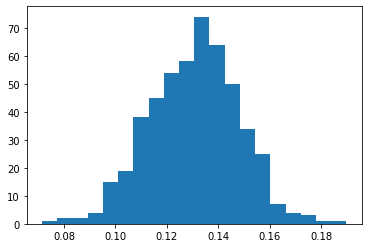

In [107]:
for _ in range(1):
    check_training('Bi_pedal_walker_v3_A3')

In [ ]:
#video1.release()